# **Speech Emotion Recognition: A Review of Feature Extraction Techniques and Classifier Models**  
**Khawla Rouchdi**  
**Yassine Hamzaoui**  
**Zakaria Baannou**  
**January 19, 2025**

---

# **Introduction to SER**  
Speech Emotion Recognition (SER) plays a crucial role in fields like human-computer interaction, customer service, and mental health monitoring, enabling machines to detect and respond to human emotions in speech. This paper provides a comprehensive review of current SER approaches, focusing on feature extraction methods and machine learning classifiers. Specifically, we compare **Deep Neural Networks (DNN)** using **Mel frequency spectral coefficients (MFCC)** with **Whisper**, a transformer-based model that utilizes **Mel spectrograms**. We analyze their performance in various conditions, particularly in noisy environments. The findings suggest that while both models are effective, Whisper outperforms DNNs in challenging scenarios. The paper also highlights key metrics and proposes future directions for SER research.

In [ ]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install librosa
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install transformers

In [2]:
import os
import time
import random
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from transformers import WhisperModel, WhisperProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **EDA**  

### **1 - Audio Files Information and Summary**

In [54]:
data_path = "/kaggle/input/tess-data/TESS"
print(os.listdir(data_path))
emotions = ['angry', 'disgust', 'fear', 'happy', 'pleasant_surprise', 'sad', 'neutral']

['YAF_pleasant_surprise', 'YAF_fear', 'OAF_angry', 'OAF_fear', 'OAF_disgust', 'OAF_neutral', 'YAF_angry', 'OAF_sad', 'YAF_disgust', 'YAF_neutral', 'OAF_pleasant_surprise', 'YAF_happy', 'OAF_happy', 'YAF_sad']


The dataset is organized into folders representing different emotions and speaker types:

- **YAF**: Young Adult Female
- **OAF**: Older Adult Female

Each folder contains audio files for specific emotions:

- **pleasant_surprise**, **fear**, **angry**, **disgust**, **neutral**, **happy**, **sad**


In [60]:
def get_audio_files_info(data_path, emotions):
    audio_info = []
    
    for emotion in emotions:
        emotion_folders = [f'YAF_{emotion}', f'OAF_{emotion}']
        for folder in emotion_folders:
            folder_path = os.path.join(data_path, folder)
            if os.path.exists(folder_path):
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    # Load audio file
                    y, sr = librosa.load(file_path)
                    
                    # Calculate features
                    duration = librosa.get_duration(y=y, sr=sr)
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                    rms = librosa.feature.rms(y=y)[0].mean()
                    zcr = librosa.feature.zero_crossing_rate(y=y)[0].mean()
                    
                    audio_info.append({
                        'file_name': file_name,
                        'emotion': emotion,
                        'speaker': 'Male' if 'YAF' in folder else 'Female',
                        'duration': duration,
                        'sample_rate': sr,
                        'rms_energy': rms,
                        'zero_crossing_rate': zcr,
                        'mfcc_mean': mfccs.mean(),
                        'mfcc_std': mfccs.std()
                    })
    
    return pd.DataFrame(audio_info)

df = get_audio_files_info(data_path, emotions)
# Summary statistics
print("\nDataset Summary:")
print(f"Total number of audio files: {len(df)}")
print("\nFiles per emotion:")
print(df['emotion'].value_counts())
print("\nFiles per speaker:")
print(df['speaker'].value_counts())

print("\nFeature Statistics:")
print(df.describe())



Dataset Summary:
Total number of audio files: 2805

Files per emotion:
emotion
pleasant_surprise    405
disgust              400
angry                400
fear                 400
happy                400
sad                  400
neutral              400
Name: count, dtype: int64

Files per speaker:
speaker
Male      1405
Female    1400
Name: count, dtype: int64

Feature Statistics:
          duration  sample_rate   rms_energy  zero_crossing_rate    mfcc_mean  \
count  2805.000000       2805.0  2805.000000         2805.000000  2805.000000   
mean      2.055006      22050.0     0.030459            0.146109   -28.964731   
std       0.320560          0.0     0.018388            0.054086     3.732210   
min       1.254104      22050.0     0.007021            0.062518   -35.607498   
25%       1.836417      22050.0     0.017205            0.100754   -32.088844   
50%       2.047120      22050.0     0.025705            0.132727   -29.482506   
75%       2.276871      22050.0     0.037869   

The dataset consists of **2,805 audio files**, with a balanced distribution of emotional categories: **pleasant_surprise (405 files)**, **disgust (400 files)**, **angry (400 files)**, **fear (400 files)**, **happy (400 files)**, **sad (400 files)**, and **neutral (400 files)**. The dataset is also well-balanced in terms of speaker gender, with **1,405 male** and **1,400 female** speakers. 

In terms of feature statistics, the **mean duration** of the audio files is **2.06 seconds** with a standard deviation of **0.32 seconds**, and all files have a consistent **sample rate of 22,050 Hz**. Key audio features include **RMS energy**, which has a mean of **0.03** and a standard deviation of **0.02**, and the **zero-crossing rate**, which has a mean of **0.15** with a standard deviation of **0.05**. The **MFCC mean** has a mean value of **-28.96** and a standard deviation of **3.73**, while the **MFCC standard deviation** has a mean of **117.74** and a standard deviation of **17.75**. These feature statistics provide valuable insights into the acoustic characteristics of the dataset, which are essential for emotion recognition and related analyses.

### **2 - Visualisations**

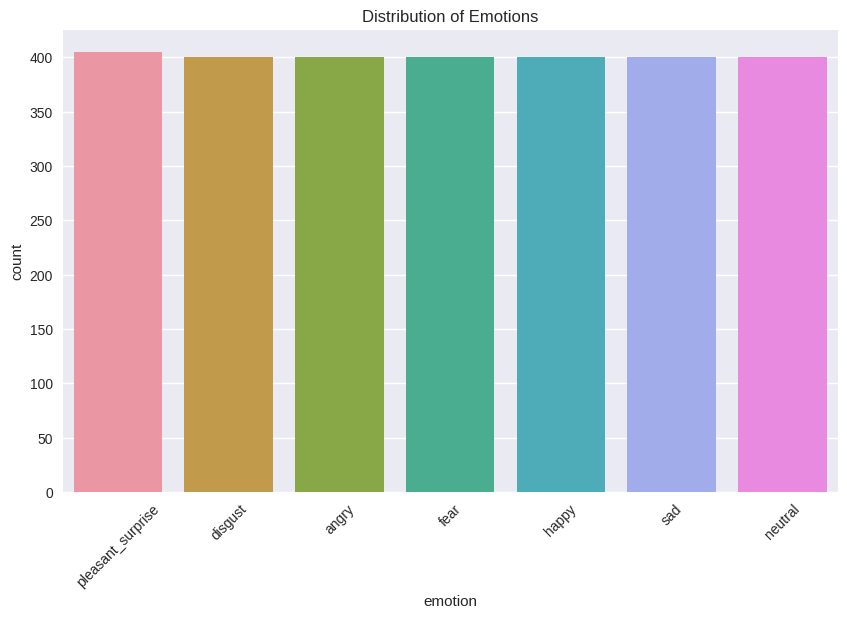

In [61]:
def plot_emotion_distribution(df):
    """Plot the distribution of emotions in the dataset."""
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
    plt.title('Distribution of Emotions')
    plt.xticks(rotation=45)
    plt.show()

plot_emotion_distribution(df)

The dataset consists of a **balanced total number of samples** for each emotion across **OAF** and **YAF**, ensuring equal representation for each class.

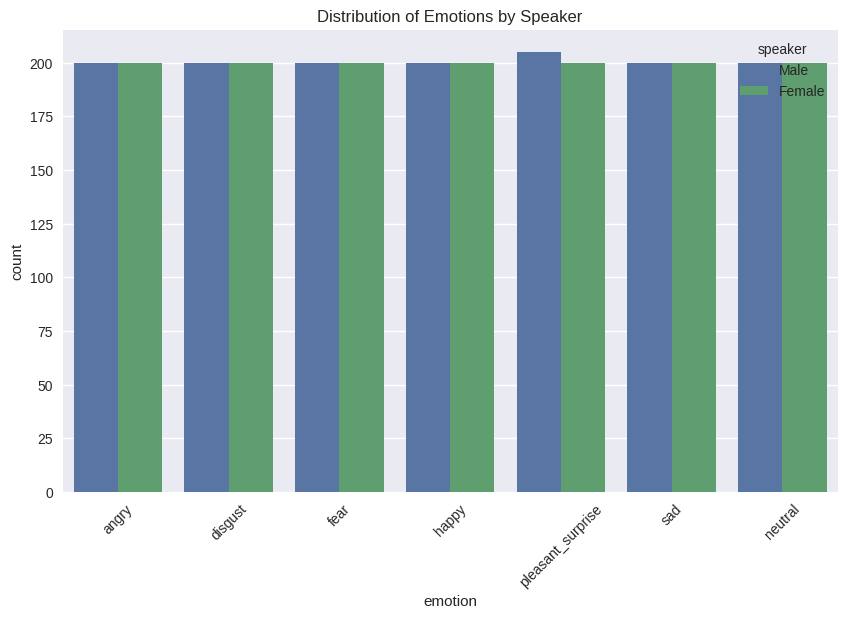

In [62]:
def plot_speaker_distribution_by_emotion(df):
    """Plot the distribution of emotions by speaker."""
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='emotion', hue='speaker')
    plt.title('Distribution of Emotions by Speaker')
    plt.xticks(rotation=45)
    plt.show()

plot_speaker_distribution_by_emotion(df)

**200 samples for each emotion** for both male and female speakers, except for the **pleasant_surprise** class, where male speakers have **5 more samples** than female speakers.

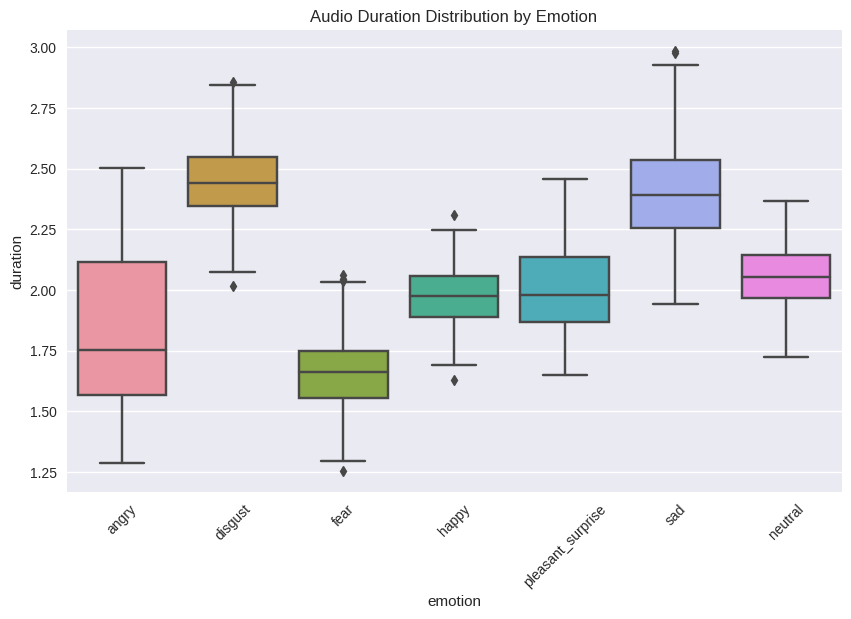

In [63]:
def plot_audio_duration_by_emotion(df):
    """Plot the distribution of audio duration by emotion."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='emotion', y='duration')
    plt.title('Audio Duration Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.show()

plot_audio_duration_by_emotion(df)

The duration of audio samples varies across emotions: **Disgust** and **Sad** have longer durations with a median around **2.4-2.5 seconds**, while **Fear** has the shortest duration with a median around **1.6 seconds**. **Neutral** emotions exhibit consistent durations with less variance, showing a tight box around **2.0 seconds**. Some outliers are present, especially in the **Sad** emotion category.

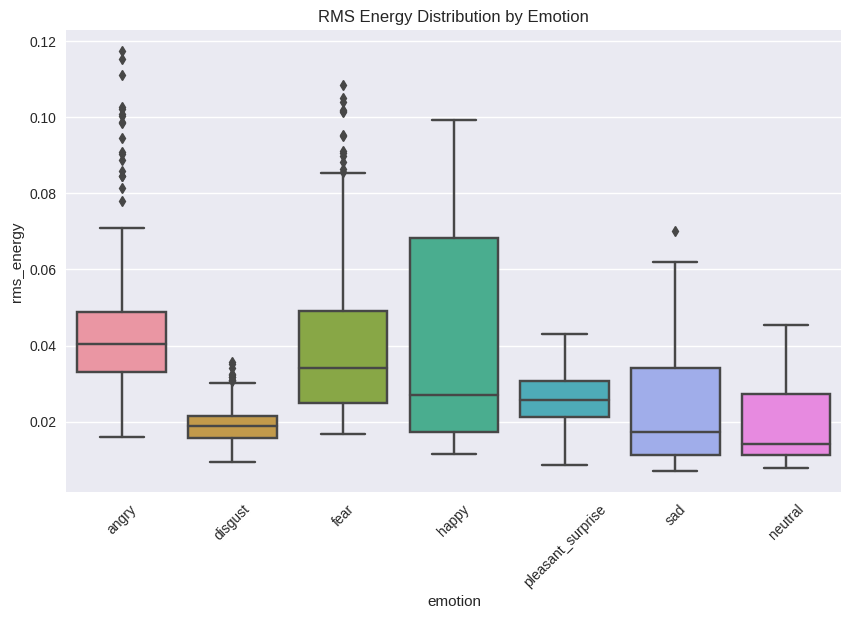

In [64]:
def plot_rms_energy_by_emotion(df):
    """Plot the distribution of RMS energy by emotion."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='emotion', y='rms_energy')
    plt.title('RMS Energy Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.show()

plot_rms_energy_by_emotion(df)

**RMS (Root Mean Square)** energy represents the amplitude/loudness of the audio. The **Angry** emotion shows the highest energy levels and most variability, with many outliers. **Fear** and **Happy** emotions display wide energy ranges, while **Disgust** has relatively low energy with a tight distribution. **Neutral** and **Sad** emotions generally have lower energy levels, with **Happy** emotions showing the widest range of energy levels.

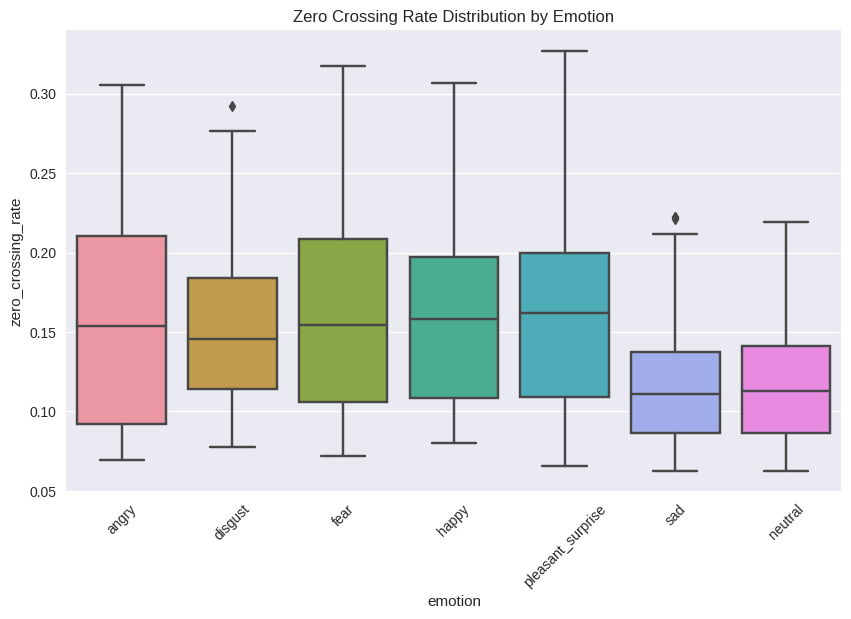

In [65]:
def plot_zero_crossing_rate_by_emotion(df):
    """Plot the distribution of zero crossing rate by emotion."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='emotion', y='zero_crossing_rate')
    plt.title('Zero Crossing Rate Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.show()

plot_zero_crossing_rate_by_emotion(df)

**Zero crossing rate** indicates the frequency content and noise level of the audio. **Angry**, **Fear**, **Happy**, and **Pleasant Surprise** show higher median rates, while **Sad** and **Neutral** emotions have notably lower zero crossing rates. **Pleasant Surprise** exhibits the highest variability. All emotions show some outliers, particularly in the upper range. There is a clear distinction between active emotions (**Angry**, **Fear**) and passive ones (**Sad**, **Neutral**).

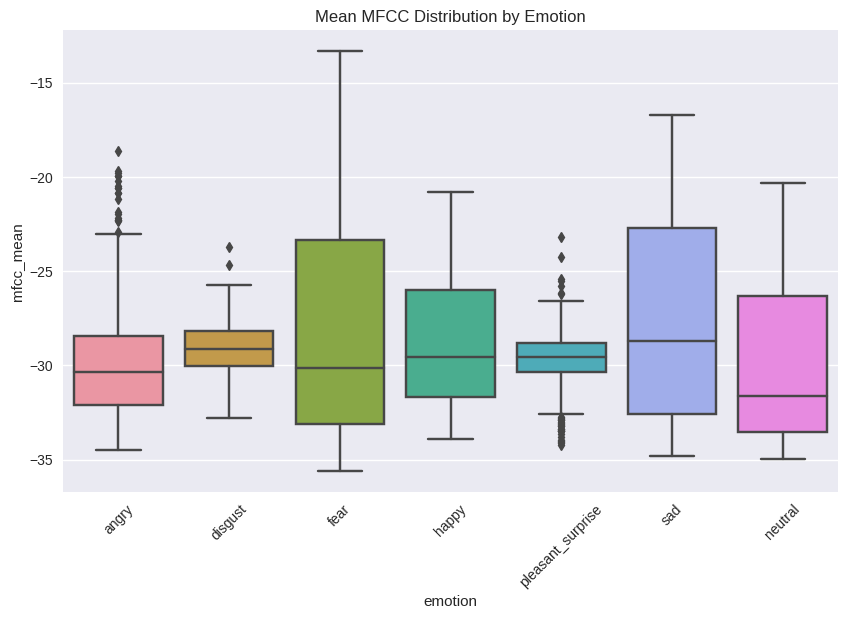

In [66]:
def plot_mfcc_by_emotion(df):
    """Plot the distribution of MFCC (mean) by emotion."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='emotion', y='mfcc_mean')
    plt.title('Mean MFCC Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.show()

plot_mfcc_by_emotion(df)

**MFCC (Mel-frequency cepstral coefficients)** represents the spectral characteristics of the audio. **Fear** shows the widest range of MFCC values, while **Sad** emotion has a distinct distribution with higher mean values. **Angry** and **Disgust** emotions show more concentrated distributions, while **Neutral** emotion exhibits moderate variability. Several outliers are present in the **Angry** emotion category.

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


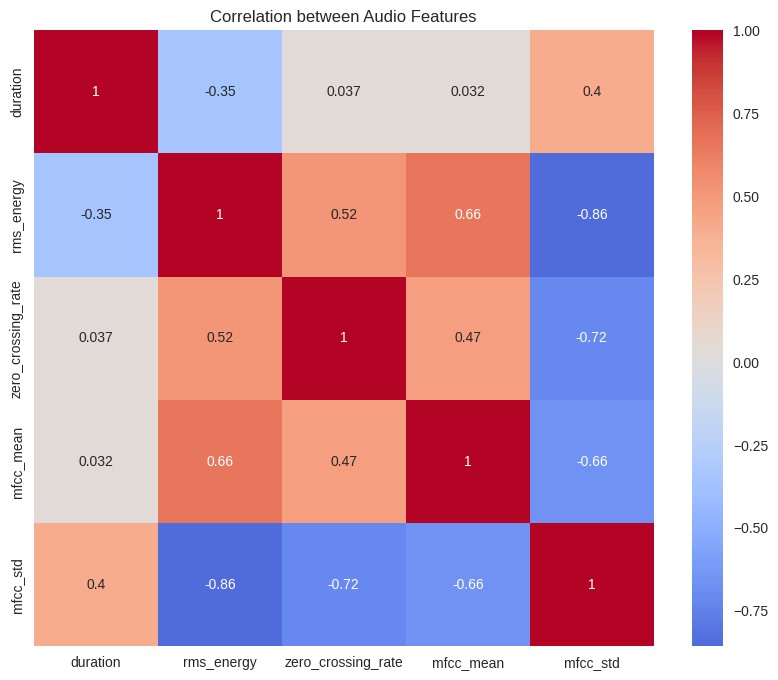

In [67]:
def plot_correlation_heatmap(df):
    """Plot the correlation heatmap of audio features."""
    plt.figure(figsize=(10, 8))
    feature_cols = ['duration', 'rms_energy', 'zero_crossing_rate', 'mfcc_mean', 'mfcc_std']
    correlation = df[feature_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Audio Features')
    plt.show()

plot_correlation_heatmap(df)

The analysis shows relationships between different audio characteristics. There is a **strong negative correlation** (-0.86) between **RMS energy** and **MFCC standard deviation**. A **moderate positive correlation** (0.66) exists between **RMS energy** and **MFCC mean**. **Duration** has weak to moderate correlations with other features. The **Zero crossing rate** shows moderate positive correlations with **RMS energy** (0.52) and **MFCC mean** (0.47). **MFCC standard deviation** generally shows negative correlations with other features.

# **Data Preparation**

### **1 - DNN dataset** 

We will create a custom dataset class, `EmotionDatasetDNN`, for emotion classification from audio files using PyTorch. This class takes a root data directory and a list of emotions. It loads audio files from the `YAF_<emotion>` and `OAF_<emotion>` folders and stores the file paths and corresponding labels.

For each emotion, the class collects audio files, and for each file, it extracts Mel-frequency cepstral coefficients (MFCCs), along with their first and second-order deltas. These features are concatenated to form the feature set. To ensure consistent input size, features are padded or truncated to 128 time frames. Finally, the features are normalized to zero mean and unit variance.

The dataset returns the extracted features as a PyTorch tensor and the corresponding emotion labels as integers for training emotion classification models.

In [3]:
class EmotionDatasetDNN(Dataset):
    def __init__(self, data_path, emotions):
        self.data_path = data_path
        self.emotions = emotions
        self.file_list = []
        self.labels = []
        
        for idx, emotion in enumerate(emotions):
            emotion_folders = [f'YAF_{emotion}', f'OAF_{emotion}']
            for folder in emotion_folders:
                folder_path = os.path.join(data_path, folder)
                if os.path.exists(folder_path):
                    for file_name in os.listdir(folder_path):
                        file_path = os.path.join(folder_path, file_name)
                        self.file_list.append(file_path)
                        self.labels.append(idx)
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path, duration=3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs])
        target_length = 128
        if features.shape[1] < target_length:
            features = np.pad(features, pad_width=((0, 0), (0, target_length - features.shape[1])), mode='constant')
        else:
            features = features[:, :target_length]
        features = (features - features.mean()) / (features.std() + 1e-8)
        return torch.FloatTensor(features), torch.tensor(label, dtype=torch.long)

### **2 - Whisper dataset** 

The `EmotionDatasetWhisper` class takes a data directory, a list of emotions, and a **processor** to handle audio data.

The class loads audio files associated with each emotion, selecting files randomly from the corresponding folders. For each file, the audio is loaded at a 16kHz sampling rate using `librosa`. The raw audio is processed using the provided processor, generating input features suitable for the Whisper model.

The dataset returns the processed input features as a tensor and the corresponding emotion label as an integer.

In [4]:
class EmotionDatasetWhisper(Dataset):
    def __init__(self, data_path, emotions, processor):
        self.data_path = data_path
        self.emotions = emotions
        self.processor = processor
        self.file_list = []
        self.labels = []

        for idx, emotion in enumerate(emotions):
            emotion_folders = [f'YAF_{emotion}', f'OAF_{emotion}']
            emotion_files = []
            for folder in emotion_folders:
                folder_path = os.path.join(data_path, folder)
                if os.path.exists(folder_path):
                    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
                    emotion_files.extend(files)
            if emotion_files:
                selected_files = random.sample(emotion_files, len(emotion_files))
                self.file_list.extend(selected_files)
                self.labels.extend([idx] * len(selected_files))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]
        speech, sr = librosa.load(file_path, sr=16000)
        inputs = self.processor(speech, sampling_rate=16000, return_tensors="pt")
        input_features = inputs.input_features.squeeze(0)
        return input_features, torch.tensor(label, dtype=torch.long)

### **2 - B16 Vision dataset** 

The `EmotionDatasetCNN` class is designed for emotion classification using PyTorch and a convolutional neural network (CNN). It takes a data directory and a list of emotions, then loads the corresponding audio files and assigns labels based on the emotion.

For each audio file, the class extracts a Mel-spectrogram using `librosa`, converts it to decibels, and pads or truncates the spectrogram to a fixed length of 224 time frames. The spectrogram is then expanded to 3 channels and resized to 224x224 pixels, preparing it for CNN input.

The dataset returns the processed Mel-spectrogram as a tensor and the corresponding emotion label as an integer.

In [5]:
class EmotionDatasetCNN(Dataset):
    def __init__(self, data_path, emotions):
        self.data_path = data_path
        self.emotions = emotions
        self.file_list = []
        self.labels = []
        self.resize = transforms.Resize((224, 224))

        for idx, emotion in enumerate(emotions):
            emotion_folders = [f'YAF_{emotion}', f'OAF_{emotion}']
            for folder in emotion_folders:
                folder_path = os.path.join(data_path, folder)
                if os.path.exists(folder_path):
                    for file_name in os.listdir(folder_path):
                        file_path = os.path.join(folder_path, file_name)
                        self.file_list.append(file_path)
                        self.labels.append(idx)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        max_length = 224
        pad_width = max_length - mel_spectrogram_db.shape[1]
        if pad_width > 0:
            mel_spectrogram_db = np.pad(mel_spectrogram_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spectrogram_db = mel_spectrogram_db[:, :max_length]
        mel_spectrogram_3ch = np.repeat(mel_spectrogram_db[np.newaxis, :, :], 3, axis=0)
        mel_spectrogram_3ch = self.resize(torch.tensor(mel_spectrogram_3ch, dtype=torch.float32))
        return torch.tensor(mel_spectrogram_3ch, dtype=torch.float32), torch.tensor(label)

# **Models**

### **1 - DNN model** 

The `EmotionDNN` class defines a **deep neural network (DNN)** model for **emotion classification**. It takes an **input size** and the **number of emotions** as arguments and uses a fully connected network architecture. The network consists of multiple layers with **ReLU activations**, **batch normalization**, and **dropout** for regularization to prevent overfitting. The final layer outputs predictions for the specified **number of emotions**. This model is designed for processing extracted features such as **MFCCs** and their **deltas**, and is suitable for tasks like **emotion recognition** from audio data.

In [6]:
class EmotionDNN(nn.Module):
    def __init__(self, input_size, num_emotions):
        super(EmotionDNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, num_emotions)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

### **2 - Whisper model** 

The `EmotionClassifierWhisper` class integrates the **Whisper model** for **emotion classification**. It takes a pre-trained Whisper model and the **number of emotions** as inputs. The Whisper model's parameters are frozen to prevent further training, and a classification layer is added on top, consisting of a **fully connected layer**, **ReLU activation**, **dropout** for regularization, and an output layer for emotion classification.

In the `forward` method, the input features are passed through the Whisper model's encoder to obtain the hidden states, which are then pooled by averaging the hidden states along the sequence dimension. The pooled features are passed through the classifier to produce the logits for the final emotion predictions.

In [7]:
class EmotionClassifierWhisper(nn.Module):
    def __init__(self, whisper_model, num_emotions):
        super().__init__()
        self.whisper = whisper_model
        for param in self.whisper.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(self.whisper.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_emotions)
        )

    def forward(self, input_features):
        outputs = self.whisper.encoder(input_features)
        pooled = outputs.last_hidden_state.mean(dim=1)
        logits = self.classifier(pooled)
        return logits

### **3 - B16 Vision model** 

The `EmotionRecognitionCNN` class leverages a **Vision Transformer (ViT)** model for emotion classification. It takes the **number of classes** (emotions) as input and allows specifying the number of **trainable layers** in the ViT. Initially, all parameters of the ViT are frozen, and only the parameters of the last `num_trainable_layers` are set to be trainable.

In the `forward` method, the input features are passed through the ViT model, which performs emotion classification using the transformed visual information. The output is the predicted emotion logits, based on the final classifier layer that is modified to have the appropriate number of output classes.

In [8]:
class EmotionRecognitionCNN(nn.Module):
    def __init__(self, num_classes, num_trainable_layers=4):
        super(EmotionRecognitionCNN, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.encoder.layers[-num_trainable_layers:].parameters():
            param.requires_grad = True
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# **Model Training and Evaluation**

The `collate_fn` function is used to combine a list of data samples into a batch, which is required by PyTorch's `DataLoader`. It takes a batch of data as input and separates the `input_features` and `labels`, stacks them into tensors, and returns them as a dictionary.



In [9]:
def collate_fn(batch):
    input_features, labels = zip(*batch)
    input_features = torch.stack(input_features)
    labels = torch.stack(labels)
    return {"input_features": input_features, "labels": labels}

The `evaluate_model` function evaluates the performance of a given model on a dataset. It computes the **loss** and **accuracy** over the entire dataset. The model is set to evaluation mode, and gradients are not computed to save memory and computation time. The function iterates through the batches, computes the output and loss, compares the predicted labels with the true labels, and accumulates the results. Finally, it returns the average loss and accuracy as a percentage.

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, dict):
                inputs = batch["input_features"].to(device)
                labels = batch["labels"].to(device)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return running_loss / len(data_loader), 100 * correct / total

## **Training functions (DNN / Whisper / B16)**

### **1 - DNN**

In [10]:
def train_and_evaluate_dnn(data_path, emotions, num_epochs=20, batch_size=32, learning_rate=0.001):
    start_time = time.time()
    dataset = EmotionDatasetDNN(data_path, emotions)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    input_size = 39 * 128
    model = EmotionDNN(input_size, len(emotions)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_acc = 0
    training_metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        training_metrics['train_loss'].append(train_loss)
        training_metrics['train_acc'].append(train_acc)
        training_metrics['val_loss'].append(val_loss)
        training_metrics['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_dnn_model.pth')
    
    training_time = time.time() - start_time
    print(f"Total training time: {training_time:.2f} seconds")
    
    model.load_state_dict(torch.load('best_dnn_model.pth'))
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return model, test_loss, test_acc, training_metrics, training_time, (y_true, y_pred)

### **2 - Whisper**

In [11]:
def train_and_evaluate_whisper(data_path, emotions, num_epochs=20, batch_size=32, learning_rate=0.001):
    start_time = time.time()
    processor = WhisperProcessor.from_pretrained("openai/whisper-small")
    whisper_model = WhisperModel.from_pretrained("openai/whisper-small")
    dataset = EmotionDatasetWhisper(data_path, emotions, processor)
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    model = EmotionClassifierWhisper(whisper_model, len(emotions)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    best_val_acc = 0
    training_metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_features = batch["input_features"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        training_metrics['train_loss'].append(train_loss)
        training_metrics['train_acc'].append(train_acc)
        training_metrics['val_loss'].append(val_loss)
        training_metrics['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_whisper_model.pth')
    
    training_time = time.time() - start_time
    print(f"Total training time: {training_time:.2f} seconds")
    
    model.load_state_dict(torch.load('best_whisper_model.pth'))
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_features = batch["input_features"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_features)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return model, test_loss, test_acc, training_metrics, training_time, (y_true, y_pred)




### **3 - B16 Vision**

In [12]:
def train_and_evaluate_cnn(data_path, emotions, num_epochs=20, batch_size=32, learning_rate=0.001):
    start_time = time.time()
    dataset = EmotionDatasetCNN(data_path, emotions)
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    model = EmotionRecognitionCNN(num_classes=len(emotions)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_acc = 0
    training_metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        training_metrics['train_loss'].append(train_loss)
        training_metrics['train_acc'].append(train_acc)
        training_metrics['val_loss'].append(val_loss)
        training_metrics['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cnn_model.pth')
    
    training_time = time.time() - start_time
    print(f"Total training time: {training_time:.2f} seconds")
    
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return model, test_loss, test_acc, training_metrics, training_time, (y_true, y_pred)

## Training

In [18]:
# Train DNN model
print("Training DNN model...")
dnn_model, dnn_test_loss, dnn_test_acc, dnn_metrics, dnn_time, dnn_confusion = train_and_evaluate_dnn(
    data_path, 
    emotions, 
    num_epochs=20
)

Training DNN model...
Epoch 1/20 - Train Loss: 59.1823, Train Acc: 69.5364, Val Loss: 0.2943, Val Acc: 93.8095
Epoch 2/20 - Train Loss: 21.8165, Train Acc: 90.9832, Val Loss: 0.1136, Val Acc: 97.8571
Epoch 3/20 - Train Loss: 13.0349, Train Acc: 94.8039, Val Loss: 0.0917, Val Acc: 98.0952
Epoch 4/20 - Train Loss: 10.2348, Train Acc: 95.4152, Val Loss: 0.0583, Val Acc: 98.8095
Epoch 5/20 - Train Loss: 7.0424, Train Acc: 97.0453, Val Loss: 0.0424, Val Acc: 99.2857
Epoch 6/20 - Train Loss: 5.9808, Train Acc: 98.0642, Val Loss: 0.0455, Val Acc: 99.0476
Epoch 7/20 - Train Loss: 5.3545, Train Acc: 97.5548, Val Loss: 0.0470, Val Acc: 98.5714
Epoch 8/20 - Train Loss: 5.1830, Train Acc: 97.8604, Val Loss: 0.0498, Val Acc: 98.8095
Epoch 9/20 - Train Loss: 5.4483, Train Acc: 97.1472, Val Loss: 0.0469, Val Acc: 98.5714
Epoch 10/20 - Train Loss: 4.2637, Train Acc: 98.2680, Val Loss: 0.0223, Val Acc: 99.5238
Epoch 11/20 - Train Loss: 3.3658, Train Acc: 98.4717, Val Loss: 0.0438, Val Acc: 98.5714
Epoc

<ipython-input-10-9dc5113a1175>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dnn_model.pth'))


Test Loss: 0.0505, Test Acc: 97.6303


In [20]:
# Train Whisper model
print("\nTraining Whisper model...")
whisper_model, whisper_test_loss, whisper_test_acc, whisper_metrics, whisper_time, whisper_confusion = train_and_evaluate_whisper(
    data_path, 
    emotions, 
    num_epochs=20
)


Training Whisper model...
Epoch 1/20 - Train Loss: 108.6380, Train Acc: 36.5767, Val Loss: 1.4702, Val Acc: 58.0952
Epoch 2/20 - Train Loss: 78.9176, Train Acc: 60.5706, Val Loss: 1.0367, Val Acc: 79.2857
Epoch 3/20 - Train Loss: 56.5195, Train Acc: 75.1401, Val Loss: 0.7130, Val Acc: 87.6190
Epoch 4/20 - Train Loss: 39.7149, Train Acc: 84.9210, Val Loss: 0.5006, Val Acc: 90.0000
Epoch 5/20 - Train Loss: 28.4838, Train Acc: 90.6266, Val Loss: 0.3551, Val Acc: 94.5238
Epoch 6/20 - Train Loss: 20.9504, Train Acc: 92.8681, Val Loss: 0.2651, Val Acc: 95.9524
Epoch 7/20 - Train Loss: 16.9105, Train Acc: 94.4982, Val Loss: 0.2142, Val Acc: 94.2857
Epoch 8/20 - Train Loss: 14.4447, Train Acc: 95.4152, Val Loss: 0.1683, Val Acc: 96.9048
Epoch 9/20 - Train Loss: 11.1948, Train Acc: 96.0774, Val Loss: 0.1418, Val Acc: 97.6190
Epoch 10/20 - Train Loss: 10.1607, Train Acc: 96.4340, Val Loss: 0.1190, Val Acc: 97.8571
Epoch 11/20 - Train Loss: 8.1684, Train Acc: 97.5038, Val Loss: 0.1069, Val Acc: 

<ipython-input-11-db5cd04d6abb>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_whisper_model.pth'))


Test Loss: 0.0393, Test Acc: 99.7630


In [21]:
# Train CNN model
print("\nTraining CNN model...")
cnn_model, cnn_test_loss, cnn_test_acc, cnn_metrics, cnn_time, cnn_confusion = train_and_evaluate_cnn(
    data_path, 
    emotions, 
    num_epochs=20
)


Training CNN model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:19<00:00, 18.2MB/s] 
<ipython-input-5-c9152bfe3a9c>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 1/20 - Train Loss: 86.8588, Train Acc: 46.1538, Val Loss: 0.5260, Val Acc: 81.9048
Epoch 2/20 - Train Loss: 16.3380, Train Acc: 90.7285, Val Loss: 0.1904, Val Acc: 94.2857
Epoch 3/20 - Train Loss: 4.7149, Train Acc: 97.6566, Val Loss: 0.0990, Val Acc: 96.4286
Epoch 4/20 - Train Loss: 4.1639, Train Acc: 97.8604, Val Loss: 0.3274, Val Acc: 92.3810
Epoch 5/20 - Train Loss: 1.9096, Train Acc: 99.0321, Val Loss: 0.1839, Val Acc: 95.4762
Epoch 6/20 - Train Loss: 2.1390, Train Acc: 98.7264, Val Loss: 0.1383, Val Acc: 94.2857
Epoch 7/20 - Train Loss: 1.7158, Train Acc: 99.0321, Val Loss: 0.1826, Val Acc: 94.5238
Epoch 8/20 - Train Loss: 5.0692, Train Acc: 97.1982, Val Loss: 0.1705, Val Acc: 95.2381
Epoch 9/20 - Train Loss: 4.3358, Train Acc: 97.9623, Val Loss: 0.1553, Val Acc: 95.9524
Epoch 10/20 - Train Loss: 0.5152, Train Acc: 99.7962, Val Loss: 0.0591, Val Acc: 98.0952
Epoch 11/20 - Train Loss: 0.0384, Train Acc: 100.0000, Val Loss: 0.0674, Val Acc: 98.5714
Epoch 12/20 - Train Loss: 0

<ipython-input-12-c0691e12d4f8>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Test Loss: 0.0475, Test Acc: 98.3412


## **Evaluation functions**

In [13]:
def plot_training_metrics(training_metrics, model_name):
    """Plot training and validation metrics over epochs."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_metrics['train_loss'], label='Training Loss')
    plt.plot(training_metrics['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(training_metrics['train_acc'], label='Training Accuracy')
    plt.plot(training_metrics['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [14]:
def plot_confusion_matrix(y_true, y_pred, emotions, model_name):
    """Plot confusion matrix for model predictions."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions, yticklabels=emotions)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [55]:
def plot_model_comparison(models_results):
    """
    Plot comparison of different models' performance.
    
    Args:
        models_results: dict with model names as keys and (test_acc, training_time) as values
    """
    models = list(models_results.keys())
    accuracies = [results[0] for results in models_results.values()]
    times = [results[1] for results in models_results.values()]
    
    # Generate diverse colors using a colormap
    colors = plt.cm.tab10(range(len(models)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Test Accuracy Comparison with diverse colors
    ax1.bar(models, accuracies, color=colors)
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_ylabel('Accuracy (%)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot Training Time Comparison with diverse colors
    ax2.bar(models, times, color=colors)
    ax2.set_title('Training Time Comparison')
    ax2.set_ylabel('Time (seconds)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## **Evaluation and comparaison**

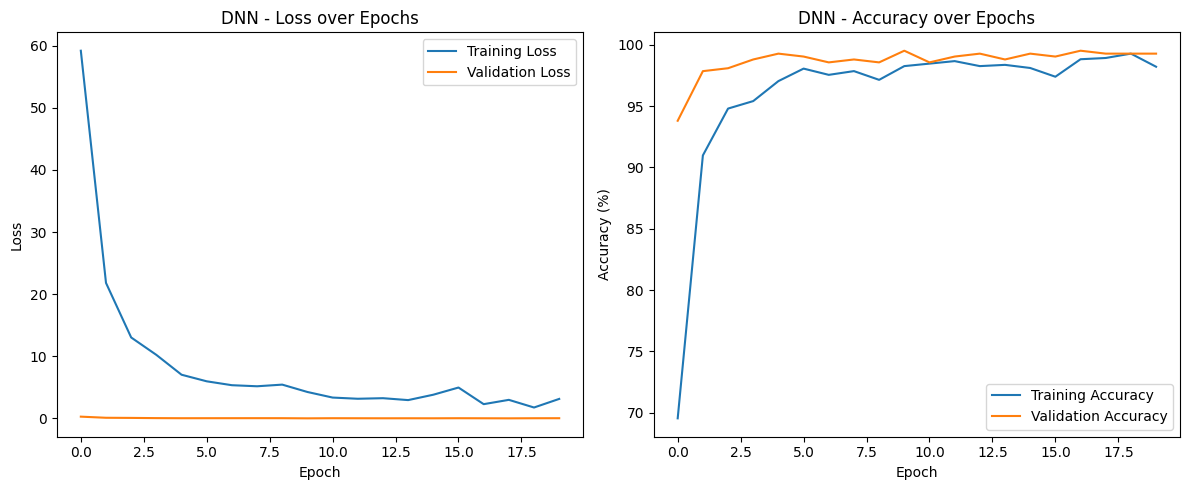

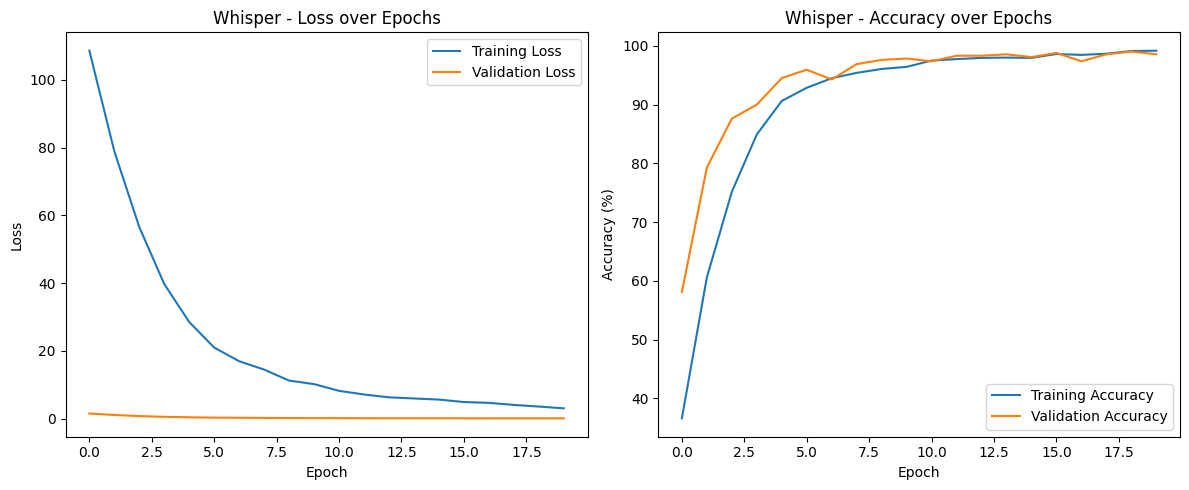

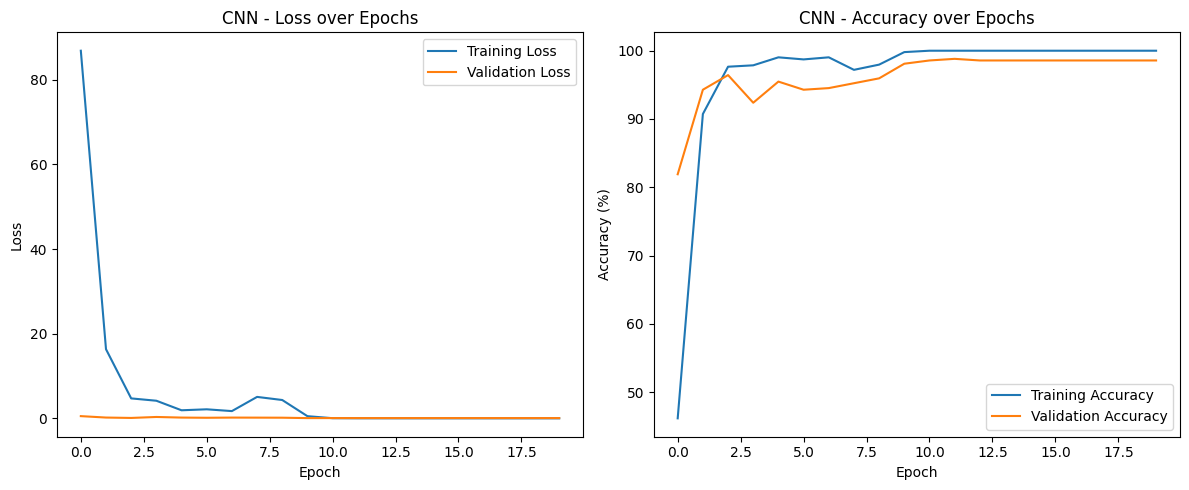

In [22]:
# Plot training metrics for each model
plot_training_metrics(dnn_metrics, "DNN")
plot_training_metrics(whisper_metrics, "Whisper")
plot_training_metrics(cnn_metrics, "CNN")

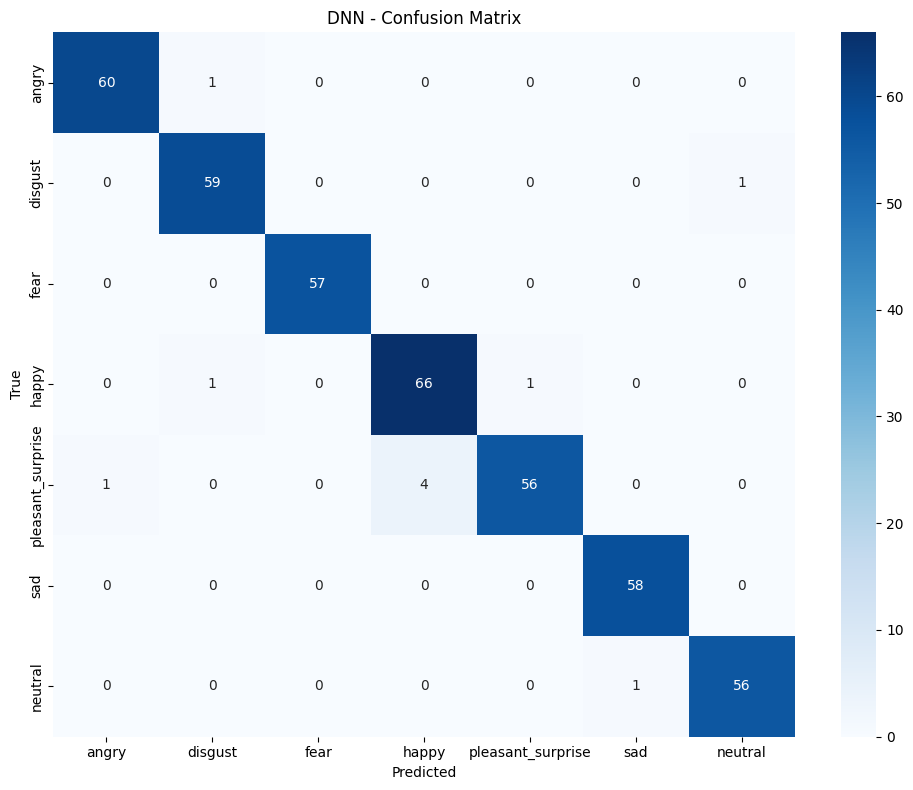

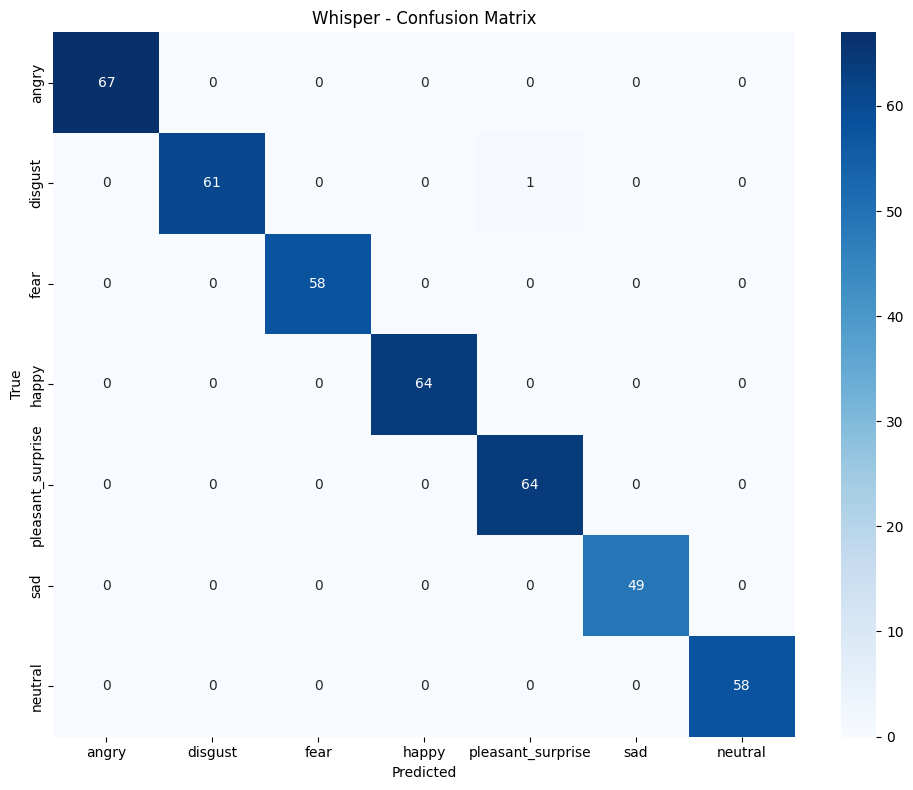

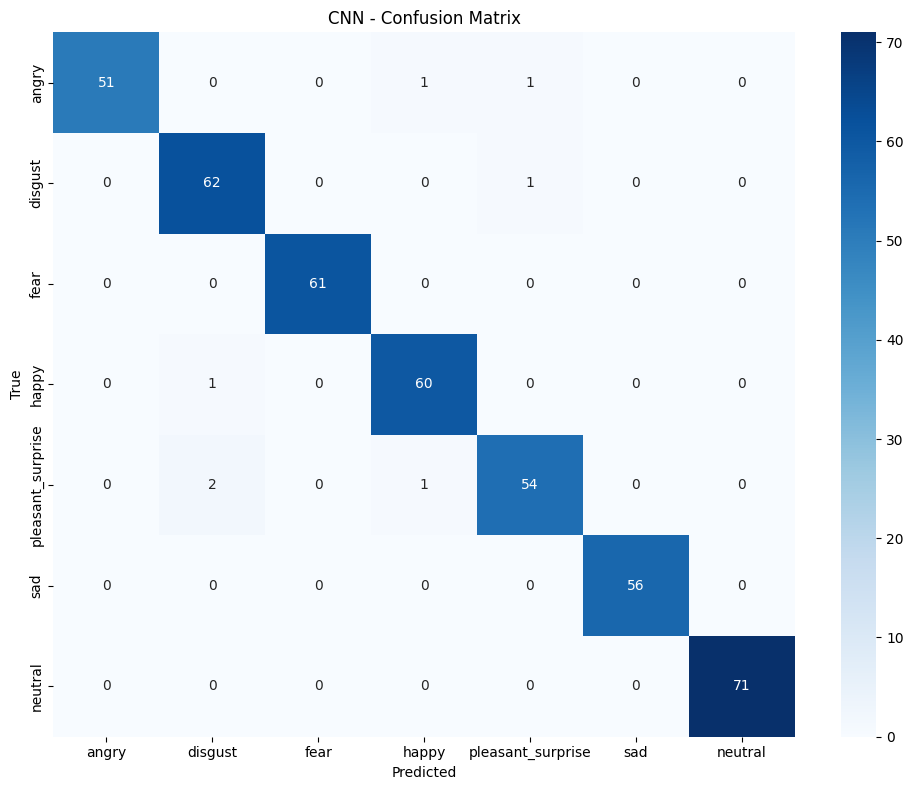

In [23]:
# Plot confusion matrices
plot_confusion_matrix(dnn_confusion[0], dnn_confusion[1], emotions, "DNN")
plot_confusion_matrix(whisper_confusion[0], whisper_confusion[1], emotions, "Whisper")
plot_confusion_matrix(cnn_confusion[0], cnn_confusion[1], emotions, "CNN")

Overall, this is an impressive performance for emotion classification, with most emotions being correctly identified. The few misclassifications that do occur are generally between emotionally similar states, which is expected in emotion recognition tasks.

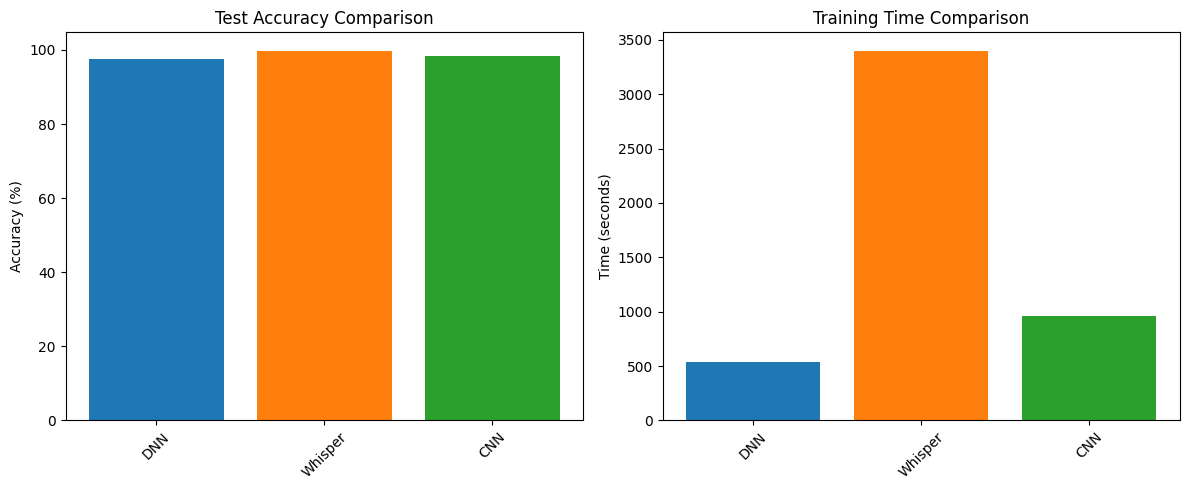

In [56]:
# Compare model performances
models_results = {
    'DNN': (dnn_test_acc, dnn_time),
    'Whisper': (whisper_test_acc, whisper_time),
    'CNN': (cnn_test_acc, cnn_time)
}
plot_model_comparison(models_results)

# **Inference**

In [25]:
# Print final results
print("\nFinal Results:")
print(f"DNN - Test Accuracy: {dnn_test_acc:.2f}%, Training Time: {dnn_time:.2f}s")
print(f"Whisper - Test Accuracy: {whisper_test_acc:.2f}%, Training Time: {whisper_time:.2f}s")
print(f"CNN - Test Accuracy: {cnn_test_acc:.2f}%, Training Time: {cnn_time:.2f}s")


Final Results:
DNN - Test Accuracy: 97.63%, Training Time: 538.55s
Whisper - Test Accuracy: 99.76%, Training Time: 3400.37s
CNN - Test Accuracy: 98.34%, Training Time: 963.11s


In [49]:
audio_file_path = "/kaggle/input/tess-data/TESS/OAF_angry/OAF_back_angry.wav"
played_audio = play_audio(audio_path)

Playing audio file...


<ipython-input-48-382e9c8a467f>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
<ipython-input-51-0082e7

tensor([[10.8476, -5.3881,  2.0353, -5.1634,  1.0857, -2.8160,  0.0898]],
       device='cuda:0')

Inference Times:
DNN: 0.0179 seconds
Whisper: 0.9100 seconds
CNN: 0.0242 seconds

Probability Distributions:

DNN Model:
angry: 0.9996
disgust: 0.0001
fear: 0.0001
happy: 0.0001
pleasant_surprise: 0.0001
sad: 0.0000
neutral: 0.0000

Whisper Model:
angry: 0.9915
disgust: 0.0001
fear: 0.0003
happy: 0.0070
pleasant_surprise: 0.0010
sad: 0.0000
neutral: 0.0001

CNN Model:
angry: 1.0000
disgust: 0.0000
fear: 0.0000
happy: 0.0000
pleasant_surprise: 0.0000
sad: 0.0000
neutral: 0.0000


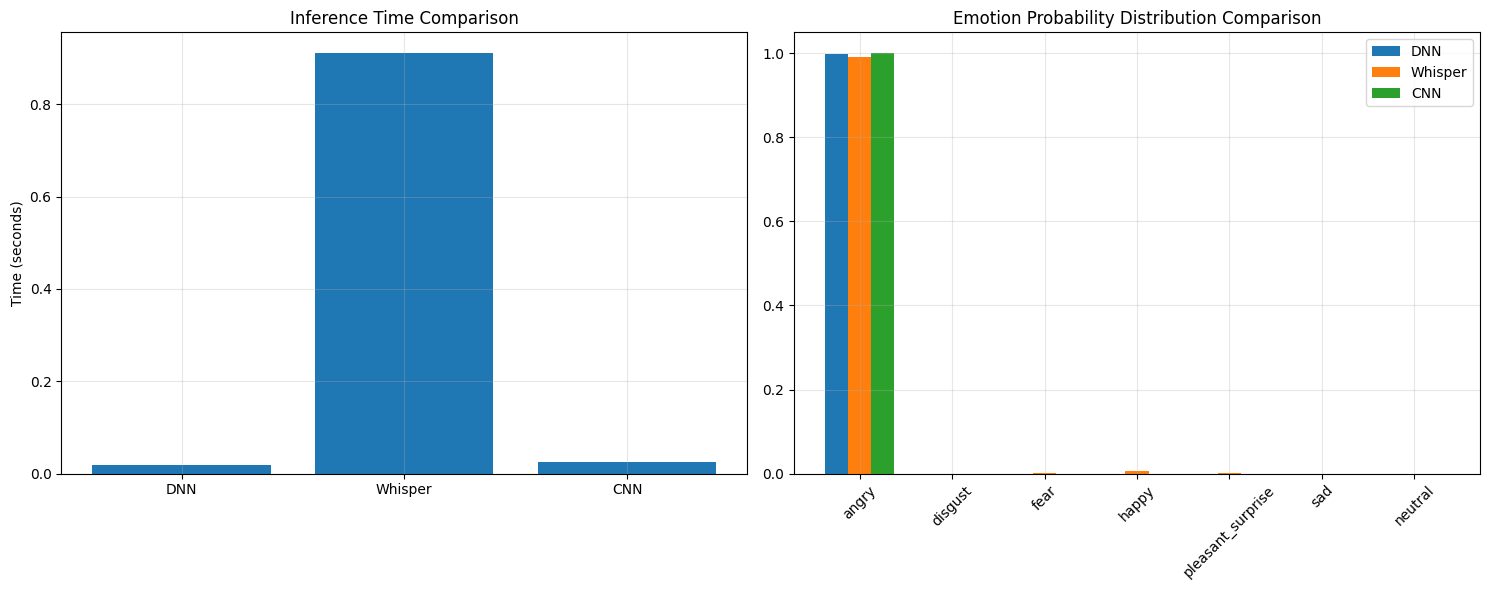

In [53]:
def run_all_models(audio_path: str, models_config: dict) -> Tuple[Dict[str, float], Dict[str, Dict[str, float]]]:
    inference_times = {}
    probability_distributions = {}
    
    # DNN Model Inference
    start_time = time.time()
    dnn_emotion, dnn_detailed, dnn_probs = inference(
        models_config['dnn']['model'], 
        audio_path, 
        models_config['emotions']
    )
    inference_times['DNN'] = time.time() - start_time
    probability_distributions['DNN'] = {e: p.item() for e, p in zip(models_config['emotions'], dnn_probs)}
    
    # Whisper Model Inference
    start_time = time.time()
    whisper_distribution = infer_emotion(
        audio_path,
        models_config['whisper']['model_path'],
        models_config['whisper']['processor'],
        models_config['whisper']['model'],
        models_config['emotions'],
        models_config['device']
    )
    inference_times['Whisper'] = time.time() - start_time
    probability_distributions['Whisper'] = whisper_distribution
    
    # CNN Model Inference
    start_time = time.time()
    cnn_emotion = predict_emotion(audio_path)
    inference_times['CNN'] = time.time() - start_time
    
    # For CNN, create artificial distribution since original function only returns class
    cnn_probs = np.zeros(len(models_config['emotions']))
    pred_idx = models_config['emotions'].index(cnn_emotion)
    cnn_probs[pred_idx] = 1.0
    probability_distributions['CNN'] = {e: p for e, p in zip(models_config['emotions'], cnn_probs)}
    
    return inference_times, probability_distributions

def plot_comparisons(inference_times: Dict[str, float], 
                    probability_distributions: Dict[str, Dict[str, float]], 
                    emotions: List[str]) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot inference times
    models = list(inference_times.keys())
    times = list(inference_times.values())
    ax1.bar(models, times)
    ax1.set_title('Inference Time Comparison')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    
    # Plot probability distributions
    x = np.arange(len(emotions))
    width = 0.25
    multiplier = 0
    
    for model_name, distribution in probability_distributions.items():
        probs = [distribution[emotion] for emotion in emotions]
        offset = width * multiplier
        ax2.bar(x + offset, probs, width, label=model_name)
        multiplier += 1
    
    ax2.set_title('Emotion Probability Distribution Comparison')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(emotions, rotation=45)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

if __name__ == "__main__":
    models_config = {
        'dnn': {
            'model': dnn_model
        },
        'whisper': {
            'model_path': "best_whisper_model.pth",
            'processor': processor,
            'model': model
        },
        'emotions': emotions,
        'device': device
    }
    
    # Run inference and create visualizations
    inference_times, probability_distributions = run_all_models(audio_file_path, models_config)
    
    # Display numerical results
    print("\nInference Times:")
    for model, time_taken in inference_times.items():
        print(f"{model}: {time_taken:.4f} seconds")
    
    print("\nProbability Distributions:")
    for model, distribution in probability_distributions.items():
        print(f"\n{model} Model:")
        for emotion, prob in distribution.items():
            print(f"{emotion}: {prob:.4f}")
    
    # Create and display plots
    plot_comparisons(inference_times, probability_distributions, models_config['emotions'])
    plt.show()